In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional, BatchNormalization, Input, Concatenate, Masking, TimeDistributed
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os

2025-04-02 16:43:48.267658: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-02 16:43:48.292146: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-02 16:43:48.292195: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-02 16:43:48.307430: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-02 16:43:49.081991: W tensorflow/compiler/tf

In [2]:
# Configure GPU
print("GPU setup:")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f"Found {len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
        print(f"Using GPU: {gpus[0].name}")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found, running on CPU")

GPU setup:
Found 1 Physical GPUs, 1 Logical GPUs
Using GPU: /physical_device:GPU:0


2025-04-02 16:43:56.447333: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14390 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0001:00:00.0, compute capability: 7.5


In [3]:
# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Load the datasets
train_df = pd.read_csv('data/train_new.csv')
test_df = pd.read_csv('data/test_new.csv')

# Combine datasets for better data utilization and cross-validation
all_data = pd.concat([train_df, test_df], ignore_index=True)
print(f"Total samples: {len(all_data)}")

Total samples: 9985


In [4]:
# Define joint columns (22 joints)
joint_columns = [
    'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow',
    'left_wrist', 'right_wrist', 'left_pinky', 'right_pinky',
    'left_index', 'right_index', 'left_thumb', 'right_thumb',
    'left_hip', 'right_hip', 'left_knee', 'right_knee',
    'left_ankle', 'right_ankle', 'left_heel', 'right_heel',
    'left_foot_index', 'right_foot_index'
]

# Examine class distribution
print("Class distribution:")
print(all_data['label'].value_counts().sort_index())

Class distribution:
label
0     504
1     346
2     409
3     400
4     204
5     416
6     407
7     444
8     432
9     669
10    429
11    389
12    792
13    456
14    449
15    369
16    410
17    405
18    582
19    521
20    502
21    450
Name: count, dtype: int64


In [5]:
# Function to parse joint position strings
def parse_joint_positions(joint_str):
    try:
        values = joint_str.strip('[]').split()
        return [float(val) for val in values]
    except (AttributeError, ValueError):
        # Handle cases where the input is already a list
        return joint_str if isinstance(joint_str, list) else []

# Parse joint positions
for col in joint_columns:
    all_data[col] = all_data[col].apply(parse_joint_positions)

In [6]:
# Define parameters for sequence creation
MIN_SEQ_LENGTH = 15  # Minimum sequence length to consider
MAX_SEQ_LENGTH = 30  # Maximum sequence length (for padding)
STRIDE = 10          # For overlapping sequences (stride < MAX_SEQ_LENGTH creates overlap)

# Function to calculate joint angles (additional features)
def calculate_joint_angles(positions):
    """Calculate angles between joints to add biomechanically relevant features"""
    angles = []
    
    # Extract joint positions
    try:
        # Shoulder-elbow-wrist angles (both sides)
        left_shoulder = np.array(positions[0])
        right_shoulder = np.array(positions[1])
        left_elbow = np.array(positions[2])
        right_elbow = np.array(positions[3])
        left_wrist = np.array(positions[4])
        right_wrist = np.array(positions[5])
        
        # Hip-knee-ankle angles (both sides)
        left_hip = np.array(positions[12])
        right_hip = np.array(positions[13])
        left_knee = np.array(positions[14])
        right_knee = np.array(positions[15])
        left_ankle = np.array(positions[16])
        right_ankle = np.array(positions[17])
        
        # Calculate elbow angles
        # Left elbow angle
        v1 = left_shoulder - left_elbow
        v2 = left_wrist - left_elbow
        
        # Normalize vectors and calculate angle
        v1_norm = np.linalg.norm(v1)
        v2_norm = np.linalg.norm(v2)
        
        if v1_norm > 0 and v2_norm > 0:
            cos_angle = np.clip(np.dot(v1, v2) / (v1_norm * v2_norm), -1.0, 1.0)
            left_elbow_angle = np.arccos(cos_angle)
            angles.append(left_elbow_angle)
        else:
            angles.append(0)
            
        # Right elbow angle
        v1 = right_shoulder - right_elbow
        v2 = right_wrist - right_elbow
        
        v1_norm = np.linalg.norm(v1)
        v2_norm = np.linalg.norm(v2)
        
        if v1_norm > 0 and v2_norm > 0:
            cos_angle = np.clip(np.dot(v1, v2) / (v1_norm * v2_norm), -1.0, 1.0)
            right_elbow_angle = np.arccos(cos_angle)
            angles.append(right_elbow_angle)
        else:
            angles.append(0)
        
        # Calculate knee angles
        # Left knee angle
        v1 = left_hip - left_knee
        v2 = left_ankle - left_knee
        
        v1_norm = np.linalg.norm(v1)
        v2_norm = np.linalg.norm(v2)
        
        if v1_norm > 0 and v2_norm > 0:
            cos_angle = np.clip(np.dot(v1, v2) / (v1_norm * v2_norm), -1.0, 1.0)
            left_knee_angle = np.arccos(cos_angle)
            angles.append(left_knee_angle)
        else:
            angles.append(0)
            
        # Right knee angle
        v1 = right_hip - right_knee
        v2 = right_ankle - right_knee
        
        v1_norm = np.linalg.norm(v1)
        v2_norm = np.linalg.norm(v2)
        
        if v1_norm > 0 and v2_norm > 0:
            cos_angle = np.clip(np.dot(v1, v2) / (v1_norm * v2_norm), -1.0, 1.0)
            right_knee_angle = np.arccos(cos_angle)
            angles.append(right_knee_angle)
        else:
            angles.append(0)
        
        # Shoulder-hip-knee angles (for posture)
        # Left side
        v1 = left_shoulder - left_hip
        v2 = left_knee - left_hip
        
        v1_norm = np.linalg.norm(v1)
        v2_norm = np.linalg.norm(v2)
        
        if v1_norm > 0 and v2_norm > 0:
            cos_angle = np.clip(np.dot(v1, v2) / (v1_norm * v2_norm), -1.0, 1.0)
            left_posture_angle = np.arccos(cos_angle)
            angles.append(left_posture_angle)
        else:
            angles.append(0)
            
        # Right side
        v1 = right_shoulder - right_hip
        v2 = right_knee - right_hip
        
        v1_norm = np.linalg.norm(v1)
        v2_norm = np.linalg.norm(v2)
        
        if v1_norm > 0 and v2_norm > 0:
            cos_angle = np.clip(np.dot(v1, v2) / (v1_norm * v2_norm), -1.0, 1.0)
            right_posture_angle = np.arccos(cos_angle)
            angles.append(right_posture_angle)
        else:
            angles.append(0)
    
    except (IndexError, TypeError):
        # Handle missing joints
        for _ in range(6):  # Add zeros for all angles we try to calculate
            angles.append(0)
    
    return angles

# Function to normalize positions relative to hip center
def normalize_positions(joint_positions):
    """Normalize positions relative to hip center to make pose invariant to position"""
    try:
        positions_array = np.array(joint_positions)
        
        # Calculate hip center as average of left and right hip
        left_hip_idx = joint_columns.index('left_hip')
        right_hip_idx = joint_columns.index('right_hip')
        
        hip_center = (positions_array[left_hip_idx] + positions_array[right_hip_idx]) / 2
        
        # Normalize by subtracting hip center
        normalized_positions = []
        for pos in positions_array:
            normalized_positions.extend(pos - hip_center)
        
        return normalized_positions
    except (IndexError, ValueError, TypeError):
        # If can't normalize, return flattened joint positions
        return [item for sublist in joint_positions for item in sublist] if joint_positions else []


## NOISE FUNCTIONS

In [7]:
def add_noise(features, noise_level=0.03):
    """Add Gaussian noise to features for data augmentation"""
    return features + np.random.normal(0, noise_level, features.shape)

def add_joint_occlusions(sequence, occlusion_prob=0.05):
    """Simulate joint occlusions by zeroing out random joints"""
    seq_copy = sequence.copy()
    frames, features = seq_copy.shape
    joint_dim = 3  # Dimension of each joint (x,y,z)
    num_joints = min(22, features // joint_dim)  # Up to 22 joints
    
    # For each frame, randomly occlude some joints
    for f in range(frames):
        for j in range(num_joints):
            if np.random.random() < occlusion_prob:
                # Zero out the joint
                start_idx = j * joint_dim
                end_idx = start_idx + joint_dim
                if start_idx < features:  # Safety check
                    seq_copy[f, start_idx:min(end_idx, features)] = 0
    
    return seq_copy

def add_joint_bias(sequence, bias_prob=0.1, max_bias=0.05):
    """Add systematic bias to random joints (simulating sensor calibration error)"""
    seq_copy = sequence.copy()
    frames, features = seq_copy.shape
    joint_dim = 3
    num_joints = min(22, features // joint_dim)
    
    # Decide which joints will have bias
    biased_joints = []
    for j in range(num_joints):
        if np.random.random() < bias_prob:
            # This joint will have a systematic bias
            bias_vector = np.random.uniform(-max_bias, max_bias, joint_dim)
            biased_joints.append((j, bias_vector))
    
    # Apply the bias to all frames for selected joints
    for j, bias_vector in biased_joints:
        start_idx = j * joint_dim
        for d in range(joint_dim):
            if start_idx + d < features:  # Safety check
                seq_copy[:, start_idx + d] += bias_vector[d]
    
    return seq_copy

def drop_frames(sequence, drop_prob=0.05):
    """Randomly drop frames by setting them to zero"""
    seq_copy = sequence.copy()
    frames, _ = seq_copy.shape
    
    # Randomly select frames to drop
    for f in range(frames):
        if np.random.random() < drop_prob:
            seq_copy[f, :] = 0
    
    return seq_copy

def simulate_wrong_execution(sequence, label, num_classes=22):
    """Simulate a person performing an exercise incorrectly"""
    seq_copy = sequence.copy()
    frames, features = seq_copy.shape
    
    # Different types of execution errors:
    error_type = np.random.randint(0, 4)
    
    if error_type == 0:
        # Type 1: Reduced range of motion (scale down movements by random factor)
        scale = np.random.uniform(0.4, 0.7)  # Reduce motion by 30-60%
        center = np.mean(seq_copy, axis=0)
        seq_copy = center + scale * (seq_copy - center)
        
    elif error_type == 1:
        # Type 2: Introduce asymmetry (affect only left or right side)
        side = np.random.randint(0, 2)  # 0=left, 1=right
        if side == 0:  # Left side
            # Find left side joints and apply distortion
            for joint_name in ['left_shoulder', 'left_elbow', 'left_wrist', 
                              'left_hip', 'left_knee', 'left_ankle']:
                if joint_name in joint_columns:
                    idx = joint_columns.index(joint_name)
                    start_idx = idx * 3
                    # Apply random scaling to joint movement
                    scale = np.random.uniform(0.6, 1.4)
                    center = np.mean(seq_copy[:, start_idx:start_idx+3], axis=0)
                    seq_copy[:, start_idx:start_idx+3] = center + scale * (seq_copy[:, start_idx:start_idx+3] - center)
        else:  # Right side
            # Find right side joints and apply distortion
            for joint_name in ['right_shoulder', 'right_elbow', 'right_wrist', 
                              'right_hip', 'right_knee', 'right_ankle']:
                if joint_name in joint_columns:
                    idx = joint_columns.index(joint_name)
                    start_idx = idx * 3
                    # Apply random scaling to joint movement
                    scale = np.random.uniform(0.6, 1.4)
                    center = np.mean(seq_copy[:, start_idx:start_idx+3], axis=0)
                    seq_copy[:, start_idx:start_idx+3] = center + scale * (seq_copy[:, start_idx:start_idx+3] - center)
    
    elif error_type == 2:
        # Type 3: Introduce jerky movements by adding high frequency noise
        jitter_scale = np.random.uniform(0.05, 0.12)  # Increased jitter for wrong execution
        for f in range(1, frames):
            if seq_copy[f].sum() != 0:  # Only add jitter to non-zero frames
                jitter = np.random.normal(0, jitter_scale, features)
                seq_copy[f] += jitter
    
    else:
        # Type 4: Mix with another exercise (blend with another class)
        # Simulate as if person is transitioning between exercises incorrectly
        other_label = (label + np.random.randint(1, num_classes)) % num_classes
        blend_factor = np.random.uniform(0.2, 0.4)  # How much to blend
        
        # We're simulating a different exercise by adding systematic bias
        # to certain joint groups depending on exercise difference
        joint_groups = [
            ['left_shoulder', 'right_shoulder'],  # Upper body focus
            ['left_elbow', 'right_elbow', 'left_wrist', 'right_wrist'],  # Arm focus
            ['left_knee', 'right_knee', 'left_ankle', 'right_ankle'],  # Leg focus
            ['left_hip', 'right_hip']  # Core focus
        ]
        
        # Choose 1-2 joint groups to modify
        num_groups = np.random.randint(1, 3)
        group_indices = np.random.choice(len(joint_groups), num_groups, replace=False)
        
        for group_idx in group_indices:
            for joint_name in joint_groups[group_idx]:
                if joint_name in joint_columns:
                    idx = joint_columns.index(joint_name)
                    start_idx = idx * 3
                    # Add directional bias
                    bias = np.random.normal(0, 0.2, 3) * blend_factor
                    seq_copy[:, start_idx:start_idx+3] += bias
    
    return seq_copy

def add_enhanced_noise(sequence, label=None, num_classes=22):
    """
    Add various types of noise to a sequence to simulate real-world conditions
    Returns: noisy sequence
    """
    # Apply base noise (higher level than before)
    noisy_seq = sequence + np.random.normal(0, 0.03, sequence.shape)
    
    # Apply various noise types with some probability
    if np.random.random() < 0.35:  # 35% chance of joint occlusions
        noisy_seq = add_joint_occlusions(noisy_seq, occlusion_prob=0.05)
    
    if np.random.random() < 0.25:  # 25% chance of systematic bias
        noisy_seq = add_joint_bias(noisy_seq, bias_prob=0.1, max_bias=0.04)
    
    if np.random.random() < 0.2:  # 20% chance of dropped frames
        noisy_seq = drop_frames(noisy_seq, drop_prob=0.05)
    
    # 40% chance of simulating wrong exercise execution
    if np.random.random() < 0.4 and label is not None:
        noisy_seq = simulate_wrong_execution(noisy_seq, label, num_classes)
    
    return noisy_seq

def introduce_label_errors(labels, error_rate=0.03, num_classes=22):
    """Introduce random label errors at the specified rate"""
    labels_copy = labels.copy()
    num_samples = len(labels)
    num_errors = int(num_samples * error_rate)
    
    # Randomly select samples to mislabel
    error_indices = np.random.choice(num_samples, num_errors, replace=False)
    
    # For each selected sample, assign a random incorrect label
    for idx in error_indices:
        current_label = labels_copy[idx]
        possible_labels = [l for l in range(num_classes) if l != current_label]
        if possible_labels:  # Make sure we have alternative labels
            labels_copy[idx] = np.random.choice(possible_labels)
    
    return labels_copy


In [8]:
# Updated sequence processing function
def process_sequences(df, max_seq_len, min_seq_len, stride, joint_cols, augment=False):
    """
    Process dataframe into sequences with variable length, padding, and augmentation
    df: DataFrame with joint positions
    max_seq_len: Maximum sequence length (for padding)
    min_seq_len: Minimum sequence length to consider
    stride: Step size for creating sequences
    joint_cols: List of joint column names
    augment: Whether to add augmented examples
    """
    sequences = []
    labels = []
    
    # Group by exercise type to keep sequences within same exercise type
    for label, group in df.groupby('label'):
        group = group.reset_index(drop=True)
        
        # Create sequences with sliding window
        for start_idx in range(0, len(group) - min_seq_len + 1, stride):
            end_idx = min(start_idx + max_seq_len, len(group))
            
            # Skip if sequence is too short
            if end_idx - start_idx < min_seq_len:
                continue
                
            sequence = group.iloc[start_idx:end_idx]
            
            # Process frames in sequence
            seq_features = []
            for _, row in sequence.iterrows():
                # Get joint positions for this frame
                joint_positions = [row[joint] for joint in joint_cols]
                
                # Normalize positions
                normalized_positions = normalize_positions(joint_positions)
                
                if not normalized_positions:  # Skip frames with invalid data
                    continue
                
                # Calculate joint angles
                joint_angles = calculate_joint_angles(joint_positions)
                
                # Combine features
                frame_features = normalized_positions + joint_angles
                seq_features.append(frame_features)
            
            # Skip if no valid frames
            if not seq_features:
                continue
                
            # Convert to numpy array
            seq_features = np.array(seq_features)
            
            # Pad sequence if shorter than max_seq_len
            if len(seq_features) < max_seq_len:
                padding = np.zeros((max_seq_len - len(seq_features), seq_features.shape[1]))
                seq_features = np.vstack([seq_features, padding])
            
            sequences.append(seq_features)
            labels.append(label)
            
            # Add augmented examples with enhanced noise
            if augment:
                # Add basic noise (increased noise level)
                aug_features1 = add_noise(seq_features.copy(), noise_level=0.03)
                sequences.append(aug_features1)
                labels.append(label)
                
                # Add enhanced noise with multiple noise types
                aug_features2 = add_enhanced_noise(seq_features.copy(), label=label)
                sequences.append(aug_features2)
                labels.append(label)
                
                # Add more challenging wrong execution example
                aug_features3 = add_enhanced_noise(seq_features.copy(), label=label)
                sequences.append(aug_features3)
                # Decide whether to keep the correct label or mislabel it
                if np.random.random() < 0.5:  # 50% chance to mislabel "wrong execution" example
                    # Assign a nearby class for more realistic confusion
                    offset = np.random.choice([-2, -1, 1, 2])
                    new_label = (label + offset) % 22  # Wrap around to stay in range 0-21
                    labels.append(new_label)
                else:
                    labels.append(label)
                
                # Add time-reversed sequence for temporal augmentation
                if len(seq_features) >= min_seq_len:
                    reversed_features = seq_features.copy()[::-1]
                    # Also add some noise to reversed sequence
                    reversed_features = add_noise(reversed_features, noise_level=0.02)
                    sequences.append(reversed_features)
                    labels.append(label)
    
    # Convert to numpy arrays
    sequences = np.array(sequences)
    labels = np.array(labels)
    
    # Introduce a small percentage of label errors to simulate real-world conditions
    if augment:
        labels = introduce_label_errors(labels, error_rate=0.03)
    
    return sequences, labels

# Process all data
print("Processing sequences...")
X, y = process_sequences(all_data, MAX_SEQ_LENGTH, MIN_SEQ_LENGTH, STRIDE, joint_columns, augment=True)

Processing sequences...


In [9]:
# Get feature dimension
feature_dim = X.shape[2]
print(f"Created {len(X)} sequences with feature dimension: {feature_dim}")
print(f"Class distribution in processed data: {np.bincount(y)}")

Created 4885 sequences with feature dimension: 72
Class distribution in processed data: [240 173 207 196 112 196 191 223 222 308 210 203 373 215 232 176 197 210
 275 247 259 220]


In [11]:
# Apply stratified k-fold cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

In [12]:
# Attention layer for the model
class AttentionLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")
        super(AttentionLayer, self).build(input_shape)
        
    def call(self, x):
        # Alignment scores. Shape: (batch_size, seq_len, 1)
        e = tf.nn.tanh(tf.matmul(x, self.W) + self.b)
        
        # Attention weights. Shape: (batch_size, seq_len, 1)
        a = tf.nn.softmax(e, axis=1)
        
        # Weighted sum. Shape: (batch_size, features)
        output = tf.reduce_sum(x * a, axis=1)
        
        return output

# Define the improved LSTM model - GPU optimized
def create_model(input_shape, num_classes=22):
    # Model inputs
    inputs = Input(shape=input_shape)
    
    # Masking layer to handle padded sequences
    x = Masking(mask_value=0.0)(inputs)
    
    # First Bidirectional LSTM layer - using CuDNNLSTM for GPU acceleration
    # Note: When using GPU, we use standard LSTM with recurrent_dropout=0
    # as CuDNNLSTM is automatically used by TF when on GPU
    x = Bidirectional(LSTM(128, return_sequences=True, 
                         recurrent_dropout=0,  # Set to 0 for GPU optimization
                         kernel_regularizer=regularizers.l2(2e-4)))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    
    # Second Bidirectional LSTM layer
    x = Bidirectional(LSTM(128, return_sequences=True,
                         recurrent_dropout=0,  # Set to 0 for GPU optimization
                         kernel_regularizer=regularizers.l2(2e-4)))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    
    # Attention mechanism
    x = AttentionLayer()(x)
    
    # Dense layers for classification
    x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(2e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)  # Increased dropout for more regularization
    
    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # Create model
    model = Model(inputs=inputs, outputs=outputs)
    
    return model


In [13]:
# Lists to store cross-validation results
cv_scores = []
all_true_labels = []
all_predictions = []
fold_histories = []

# Create directory for saving models - do this before the fold loop
# This was causing the error - we need to ensure the directory exists
os.makedirs('model_checkpoints', exist_ok=True)

In [14]:
# Run cross-validation
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n---- Fold {fold+1}/{n_splits} ----")
    
    # Split data
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
    # Normalize the data (important for LSTM)
    # Compute mean and std on training data only
    mean = np.mean(X_train, axis=(0, 1), keepdims=True)
    std = np.std(X_train, axis=(0, 1), keepdims=True)
    std = np.where(std < 1e-6, 1e-6, std)  # Avoid division by zero
    
    # Apply normalization
    X_train = (X_train - mean) / std
    X_val = (X_val - mean) / std
    
    # Compute class weights to handle imbalance
    from sklearn.utils.class_weight import compute_class_weight
    class_weights = compute_class_weight(class_weight='balanced', 
                                         classes=np.unique(y_train), 
                                         y=y_train)
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
    
    # Create model
    model = create_model((MAX_SEQ_LENGTH, feature_dim))
    
    if fold == 0:
        model.summary()
    
    # Modified callbacks - no ModelCheckpoint for now to avoid file issues
    callbacks_list = [
        callbacks.EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True  # Keep weights in memory instead of saving to disk
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6
        )
    ]
    
    # Removed mixed precision policy to simplify troubleshooting
    # Compile model with standard precision
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Train the model - simplified approach
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=64,
        validation_data=(X_val, y_val),
        class_weight=class_weight_dict,
        callbacks=callbacks_list,
        verbose=1
    )
    
    # Evaluate on validation set
    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
    cv_scores.append(val_acc)
    
    # Make predictions
    y_pred = np.argmax(model.predict(X_val), axis=1)
    all_true_labels.extend(y_val)
    all_predictions.extend(y_pred)
    
    # Save history for later plotting
    fold_histories.append(history)
    
    # Manually save model to avoid file path issues
    try:
        model_path = f'model_fold_{fold+1}.h5'
        model.save(model_path)
        print(f"Model saved to {model_path}")
    except Exception as e:
        print(f"Warning: Could not save model: {str(e)}")
    
    print(f"Fold {fold+1} - Validation Accuracy: {val_acc:.4f}")



---- Fold 1/5 ----


/opt/conda/lib/python3.11/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'attention_layer' (of type AttentionLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 72)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 30, 72)    │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 30, 72)    │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, 30)        │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 30, 256)   │    205,824 │ masking[0][0],    │
│ (Bidirectional)     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 30, 256)   │      1,024 │ bidirectional[0]… │
│ (BatchNormalizatio… │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 30, 256)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 30, 256)   │    394,240 │ dropout[0][0],    │
│ (Bidirectional)     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 256)   │      1,024 │ bidirectional_1[… │
│ (BatchNormalizatio… │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 30, 256)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, 256)       │        286 │ dropout_1[0][0]   │
│ (AttentionLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     32,896 │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 22)        │      2,838 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 638,644 (2.44 MB)

 Trainable params: 637,364 (2.43 MB)

 Non-trainable params: 1,280 (5.00 KB)

Epoch 1/50


2025-04-02 16:47:18.203637: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.4474 - loss: 2.4683 - val_accuracy: 0.7932 - val_loss: 2.0810 - learning_rate: 0.0010
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7698 - loss: 1.3459 - val_accuracy: 0.8321 - val_loss: 1.4636 - learning_rate: 0.0010
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8164 - loss: 1.1902 - val_accuracy: 0.8557 - val_loss: 1.1475 - learning_rate: 0.0010
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8351 - loss: 1.1006 - val_accuracy: 0.8608 - val_loss: 1.0630 - learning_rate: 0.0010
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8554 - loss: 1.0161 - val_accuracy: 0.8628 - val_loss: 1.0825 - learning_rate: 0.0010
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8545 - loss: 0.9632 - val_accuracy: 0.8680 - val_loss: 1.0851 - learning_rate: 0.0010
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8630 - loss: 0.9246 - val_accuracy: 0.86

Model saved to model_fold_1.h5
Fold 1 - Validation Accuracy: 0.8608

---- Fold 2/5 ----
Epoch 1/50


/opt/conda/lib/python3.11/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'attention_layer_1' (of type AttentionLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.4486 - loss: 2.5397 - val_accuracy: 0.8209 - val_loss: 2.0139 - learning_rate: 0.0010
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7453 - loss: 1.4465 - val_accuracy: 0.8639 - val_loss: 1.3554 - learning_rate: 0.0010
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7948 - loss: 1.2502 - val_accuracy: 0.8731 - val_loss: 1.0374 - learning_rate: 0.0010
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8283 - loss: 1.1545 - val_accuracy: 0.8762 - val_loss: 0.9528 - learning_rate: 0.0010
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8338 - loss: 1.0701 - val_accuracy: 0.8864 - val_loss: 0.9687 - learning_rate: 0.0010
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8498 - loss: 1.0197 - val_accuracy: 0.8854 - val_loss: 0.9580 - learning_rate: 0.0010
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8547 - loss: 0.9597 - val_accuracy: 0.88

Model saved to model_fold_2.h5
Fold 2 - Validation Accuracy: 0.8762

---- Fold 3/5 ----
Epoch 1/50


/opt/conda/lib/python3.11/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'attention_layer_2' (of type AttentionLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.4759 - loss: 2.4238 - val_accuracy: 0.7861 - val_loss: 2.0912 - learning_rate: 0.0010
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7666 - loss: 1.3261 - val_accuracy: 0.8219 - val_loss: 1.5130 - learning_rate: 0.0010
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8135 - loss: 1.1731 - val_accuracy: 0.8301 - val_loss: 1.2134 - learning_rate: 0.0010
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8359 - loss: 1.0657 - val_accuracy: 0.8424 - val_loss: 1.1405 - learning_rate: 0.0010
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8489 - loss: 1.0110 - val_accuracy: 0.8424 - val_loss: 1.1559 - learning_rate: 0.0010
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8563 - loss: 0.9531 - val_accuracy: 0.8495 - val_loss: 1.1714 - learning_rate: 0.0010
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8607 - loss: 0.9323 - val_accuracy: 0.85

Model saved to model_fold_3.h5
Fold 3 - Validation Accuracy: 0.8424

---- Fold 4/5 ----
Epoch 1/50


/opt/conda/lib/python3.11/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'attention_layer_3' (of type AttentionLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.4420 - loss: 2.5137 - val_accuracy: 0.8035 - val_loss: 2.0997 - learning_rate: 0.0010
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7581 - loss: 1.3663 - val_accuracy: 0.8547 - val_loss: 1.4505 - learning_rate: 0.0010
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8086 - loss: 1.1998 - val_accuracy: 0.8649 - val_loss: 1.1406 - learning_rate: 0.0010
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8319 - loss: 1.1251 - val_accuracy: 0.8639 - val_loss: 1.0740 - learning_rate: 0.0010
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8483 - loss: 1.0398 - val_accuracy: 0.8690 - val_loss: 1.0730 - learning_rate: 0.0010
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8401 - loss: 1.0211 - val_accuracy: 0.8669 - val_loss: 1.0855 - learning_rate: 0.0010
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8506 - loss: 0.9641 - val_accuracy: 0.87

Model saved to model_fold_4.h5
Fold 4 - Validation Accuracy: 0.8690

---- Fold 5/5 ----
Epoch 1/50


/opt/conda/lib/python3.11/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'attention_layer_4' (of type AttentionLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.4458 - loss: 2.4852 - val_accuracy: 0.8035 - val_loss: 2.0092 - learning_rate: 0.0010
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7626 - loss: 1.3629 - val_accuracy: 0.8649 - val_loss: 1.3838 - learning_rate: 0.0010
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8144 - loss: 1.1805 - val_accuracy: 0.8690 - val_loss: 1.0825 - learning_rate: 0.0010
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8355 - loss: 1.0907 - val_accuracy: 0.8731 - val_loss: 1.0114 - learning_rate: 0.0010
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8482 - loss: 1.0467 - val_accuracy: 0.8731 - val_loss: 1.0138 - learning_rate: 0.0010
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8501 - loss: 0.9944 - val_accuracy: 0.8762 - val_loss: 1.0167 - learning_rate: 0.0010
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8575 - loss: 0.9426 - val_accuracy: 0.87

Model saved to model_fold_5.h5
Fold 5 - Validation Accuracy: 0.8731


In [15]:
# Print cross-validation results
print(f"\nCross-Validation Results:")
for i, score in enumerate(cv_scores):
    print(f"Fold {i+1}: {score:.4f}")
print(f"Mean Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")


Cross-Validation Results:
Fold 1: 0.8608
Fold 2: 0.8762
Fold 3: 0.8424
Fold 4: 0.8690
Fold 5: 0.8731
Mean Accuracy: 0.8643 ± 0.0121


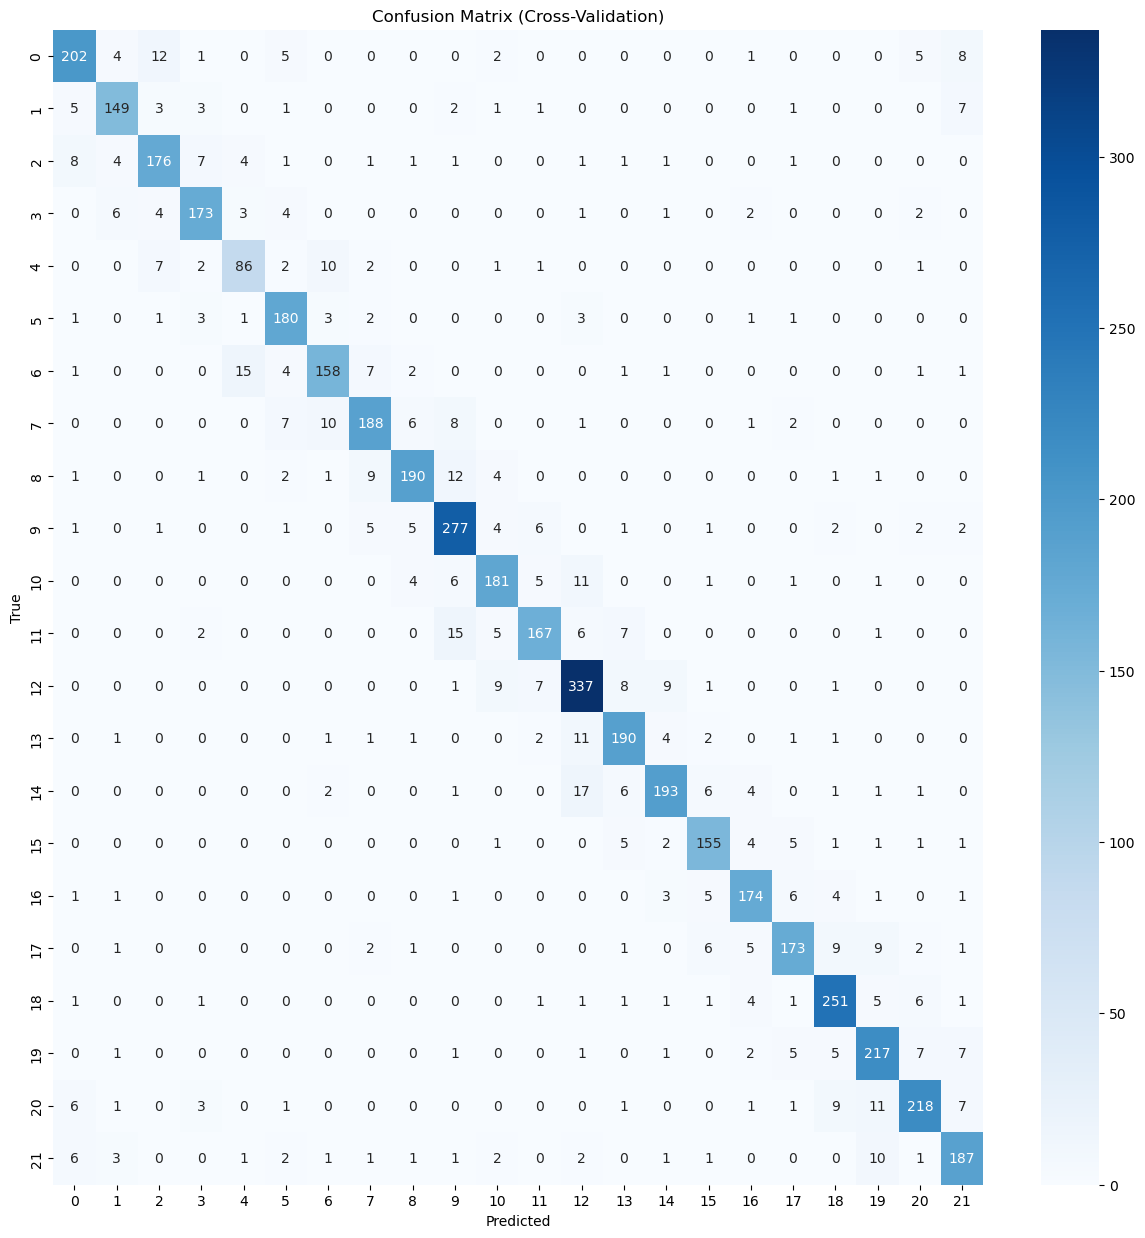

In [20]:
# Overall confusion matrix
cm = confusion_matrix(all_true_labels, all_predictions)
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Cross-Validation)')
plt.savefig('confusion_matrix_cv.png')
plt.show()

In [21]:
# Classification report
print("\nClassification Report:")
print(classification_report(all_true_labels, all_predictions))


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.84      0.85       240
           1       0.87      0.86      0.87       173
           2       0.86      0.85      0.86       207
           3       0.88      0.88      0.88       196
           4       0.78      0.77      0.77       112
           5       0.86      0.92      0.89       196
           6       0.85      0.83      0.84       191
           7       0.86      0.84      0.85       223
           8       0.90      0.86      0.88       222
           9       0.85      0.90      0.87       308
          10       0.86      0.86      0.86       210
          11       0.88      0.82      0.85       203
          12       0.86      0.90      0.88       373
          13       0.86      0.88      0.87       215
          14       0.89      0.83      0.86       232
          15       0.87      0.88      0.87       176
          16       0.87      0.88      0.88       197
   

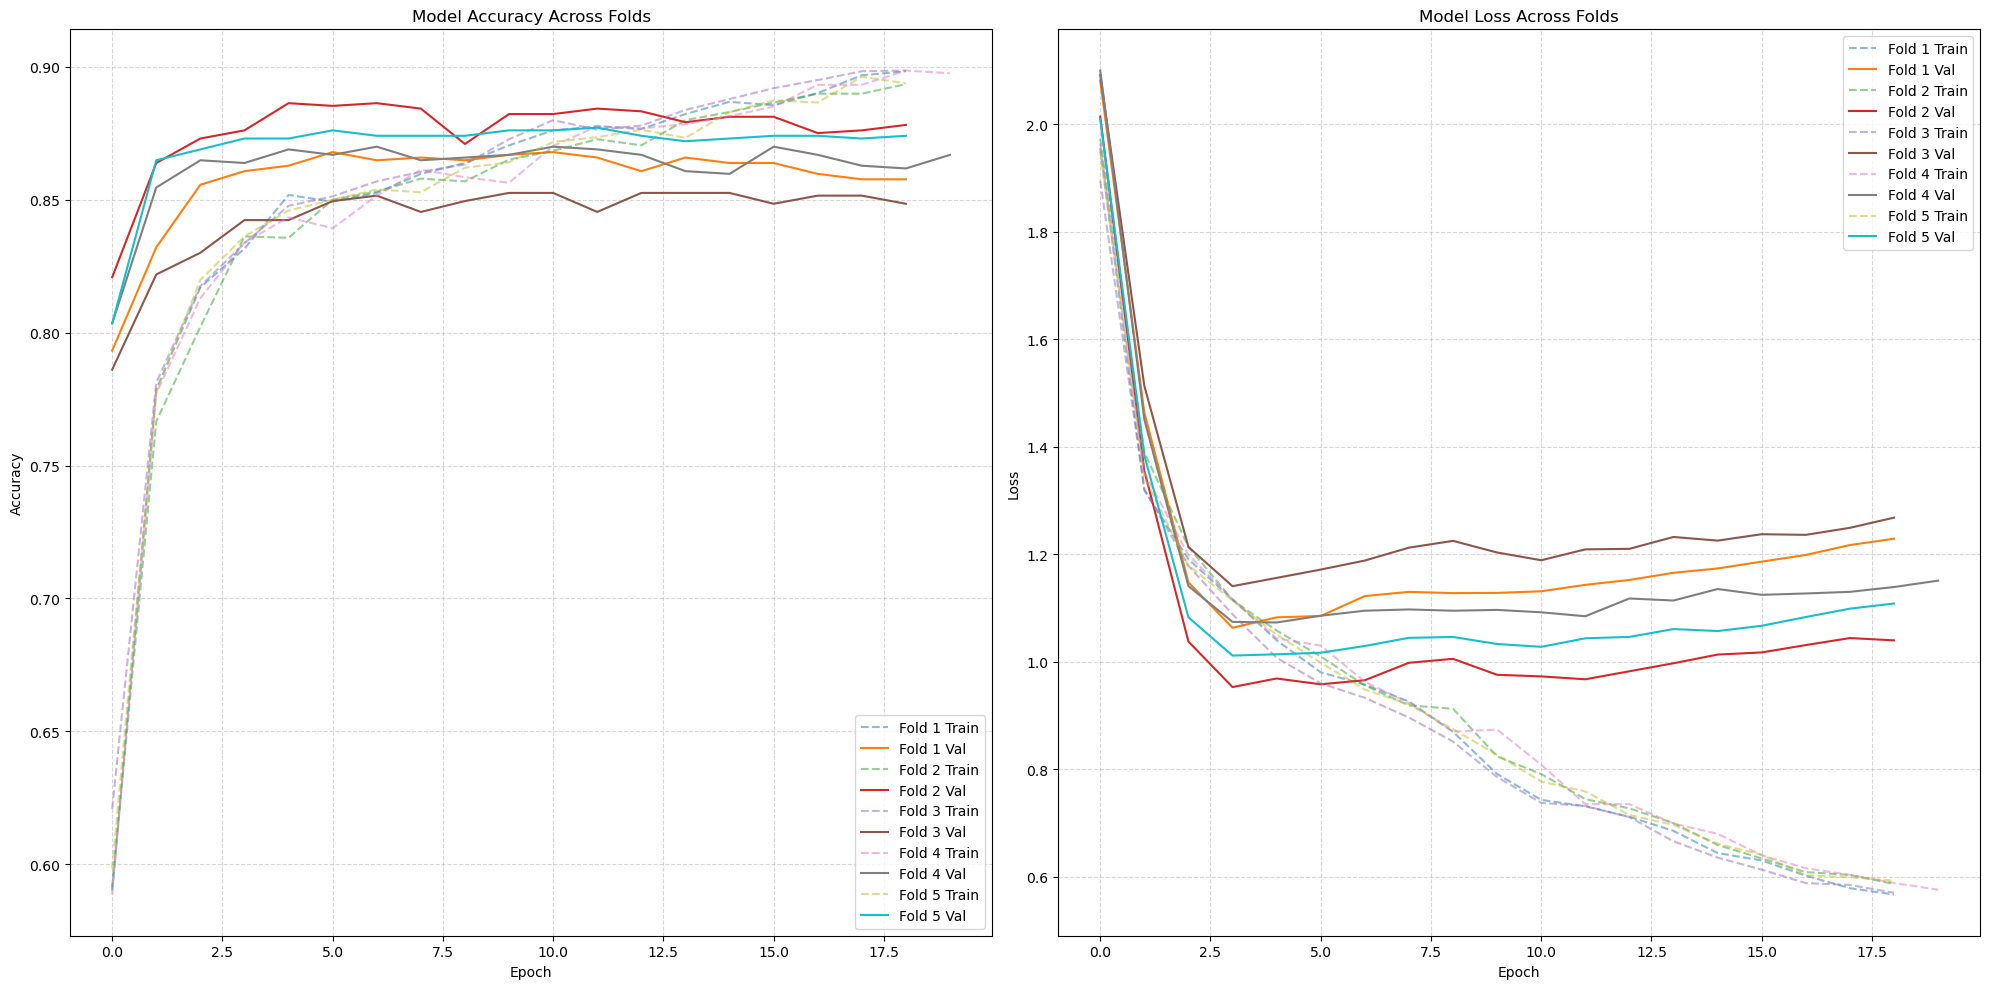

In [22]:
# Plot learning curves for each fold
plt.figure(figsize=(20, 10))

# Plot accuracy
plt.subplot(1, 2, 1)
for i, history in enumerate(fold_histories):
    plt.plot(history.history['accuracy'], linestyle='--', alpha=0.5, label=f'Fold {i+1} Train')
    plt.plot(history.history['val_accuracy'], label=f'Fold {i+1} Val')

plt.title('Model Accuracy Across Folds')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# Plot loss
plt.subplot(1, 2, 2)
for i, history in enumerate(fold_histories):
    plt.plot(history.history['loss'], linestyle='--', alpha=0.5, label=f'Fold {i+1} Train')
    plt.plot(history.history['val_loss'], label=f'Fold {i+1} Val')

plt.title('Model Loss Across Folds')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('training_history_cv.png')
plt.show()

In [23]:
# Save the best model from CV - simplified approach to avoid file issues
best_fold = np.argmax(cv_scores)
try:
    best_model = tf.keras.models.load_model(f'model_fold_{best_fold+1}.h5', 
                                          custom_objects={'AttentionLayer': AttentionLayer})
    best_model.save('best_exercise_classifier.h5')
    print(f"Best model (from fold {best_fold+1}) saved to best_exercise_classifier.h5")
except Exception as e:
    print(f"Warning: Could not load/save best model: {str(e)}")

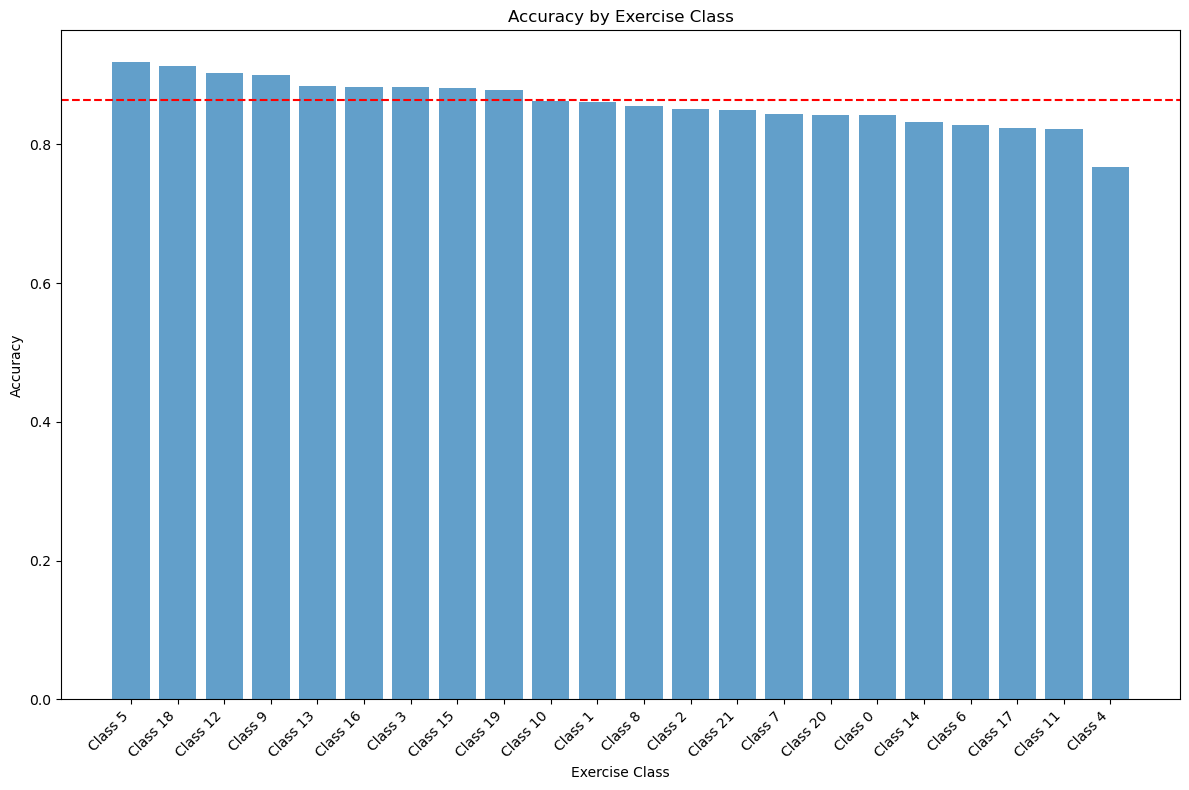

In [24]:
# Analyze performance by class
class_accuracies = []
for cls in range(22):  # Assuming 22 classes
    cls_indices = [i for i, label in enumerate(all_true_labels) if label == cls]
    if cls_indices:  # Check if we have examples for this class
        cls_preds = [all_predictions[i] for i in cls_indices]
        cls_true = [all_true_labels[i] for i in cls_indices]
        cls_acc = sum(1 for p, t in zip(cls_preds, cls_true) if p == t) / len(cls_indices)
        class_accuracies.append((cls, cls_acc, len(cls_indices)))
    else:
        class_accuracies.append((cls, 0, 0))

# Sort by accuracy
class_accuracies.sort(key=lambda x: x[1], reverse=True)

# Plot class accuracies
plt.figure(figsize=(12, 8))
classes = [f"Class {cls}" for cls, _, _ in class_accuracies]
accuracies = [acc for _, acc, _ in class_accuracies]
counts = [count for _, _, count in class_accuracies]

plt.bar(classes, accuracies, alpha=0.7)
plt.axhline(y=np.mean(cv_scores), color='r', linestyle='--', label=f"Mean Accuracy: {np.mean(cv_scores):.2f}")
plt.xticks(rotation=45, ha='right')
plt.xlabel('Exercise Class')
plt.ylabel('Accuracy')
plt.title('Accuracy by Exercise Class')
plt.tight_layout()
plt.savefig('class_accuracies.png')
plt.show()

In [25]:
# Final summary
print(f"\nFinal Model Summary:")
print(f"Number of training sequences: {len(X)}")
print(f"Feature dimension: {feature_dim}")
print(f"Cross-validation accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
print("Model saved to 'best_exercise_classifier.h5'")


Final Model Summary:
Number of training sequences: 4885
Feature dimension: 72
Cross-validation accuracy: 0.8643 ± 0.0121
Model saved to 'best_exercise_classifier.h5'


In [ ]:
# Generate incorrect data frames and visualize skeletons in 3D
import plotly.graph_objects as go
import numpy as np

def generate_wrong_skeleton_data(correct_sequence, joint_columns):
    """Generate an incorrect version of a skeleton sequence with various error types"""
    # Create a deep copy to avoid modifying original
    wrong_sequence = correct_sequence.copy()
    
    # Choose a random error type (0-4)
    error_type = np.random.randint(0, 5)
    
    if error_type == 0:
        # Type 1: Reduced range of motion (scale movements)
        scale = np.random.uniform(0.4, 0.7)  # Reduce motion by 30-60%
        center = np.mean(wrong_sequence, axis=0)
        wrong_sequence = center + scale * (wrong_sequence - center)
        error_description = "Reduced range of motion"
        
    elif error_type == 1:
        # Type 2: Joint asymmetry (left vs right)
        side = 'left' if np.random.random() < 0.5 else 'right'
        
        # Find indices of joints on the selected side
        side_joints = []
        for j, joint_name in enumerate(joint_columns):
            if joint_name.startswith(side):
                side_joints.append(j)
        
        # Apply random scaling to those joints
        scale = np.random.uniform(0.6, 1.4)
        
        for j in side_joints:
            start_idx = j * 3
            end_idx = start_idx + 3
            
            if start_idx < wrong_sequence.shape[1]:
                # Apply scaling (only for non-zero frames)
                for f in range(len(wrong_sequence)):
                    if not np.all(wrong_sequence[f, start_idx:min(end_idx, wrong_sequence.shape[1])] == 0):
                        joint_mean = np.mean(wrong_sequence[:, start_idx:min(end_idx, wrong_sequence.shape[1])], axis=0)
                        wrong_sequence[f, start_idx:min(end_idx, wrong_sequence.shape[1])] = joint_mean + scale * (
                            wrong_sequence[f, start_idx:min(end_idx, wrong_sequence.shape[1])] - joint_mean)
        
        error_description = f"Asymmetry ({side} side distorted)"
        
    elif error_type == 2:
        # Type 3: Add jerky movements (high-frequency noise)
        jitter_scale = np.random.uniform(0.05, 0.15)
        for f in range(1, len(wrong_sequence)):
            if not np.all(wrong_sequence[f] == 0):  # Skip zero frames
                jitter = np.random.normal(0, jitter_scale, wrong_sequence.shape[1])
                wrong_sequence[f] += jitter
        
        error_description = "Jerky movements (high-frequency noise)"
        
    elif error_type == 3:
        # Type 4: Joint misalignment
        # Choose random joints to misalign
        num_joints = len(joint_columns)
        num_to_misalign = np.random.randint(1, 4)  # Misalign 1-3 joints
        joints_to_misalign = np.random.choice(num_joints, num_to_misalign, replace=False)
        
        for joint_idx in joints_to_misalign:
            start_idx = joint_idx * 3
            end_idx = start_idx + 3
            
            if start_idx < wrong_sequence.shape[1]:
                # Add a constant offset to simulate misalignment
                offset = np.random.normal(0, 0.2, 3)
                wrong_sequence[:, start_idx:min(end_idx, wrong_sequence.shape[1])] += offset
        
        misaligned_joints = [joint_columns[i] for i in joints_to_misalign]
        error_description = f"Joint misalignment ({', '.join(misaligned_joints)})"
        
    else:
        # Type 5: Combined errors - occlusions and bias
        # Occlusions (zeroing out joints)
        occlusion_prob = 0.05
        for f in range(len(wrong_sequence)):
            if not np.all(wrong_sequence[f] == 0):  # Skip zero frames
                for j in range(len(joint_columns)):
                    if np.random.random() < occlusion_prob:
                        start_idx = j * 3
                        end_idx = start_idx + 3
                        if start_idx < wrong_sequence.shape[1]:
                            wrong_sequence[f, start_idx:min(end_idx, wrong_sequence.shape[1])] = 0
        
        # Systematic bias
        bias_prob = 0.1
        max_bias = 0.05
        for j in range(len(joint_columns)):
            if np.random.random() < bias_prob:
                start_idx = j * 3
                bias_vector = np.random.uniform(-max_bias, max_bias, 3)
                for d in range(3):
                    if start_idx + d < wrong_sequence.shape[1]:
                        wrong_sequence[:, start_idx + d] += bias_vector[d]
        
        error_description = "Combined errors (occlusions and bias)"
    
    return wrong_sequence, error_description


def extract_joint_positions(sequence, joint_columns):
    """Extract 3D positions of all joints from a sequence"""
    frames = []
    
    # Process each frame
    for frame_idx in range(len(sequence)):
        frame_features = sequence[frame_idx]
        
        # Skip padding frames (all zeros)
        if np.all(frame_features == 0):
            continue
        
        frame_data = {}
        
        # Extract joint positions (assuming 3 values per joint: x,y,z)
        for j, joint_name in enumerate(joint_columns):
            start_idx = j * 3
            
            # Check if we have enough features
            if start_idx + 2 < len(frame_features):
                # Skip joints with all zeros (occluded/missing)
                if not np.all(frame_features[start_idx:start_idx+3] == 0):
                    frame_data[joint_name] = {
                        'x': float(frame_features[start_idx]),
                        'y': float(frame_features[start_idx + 1]),
                        'z': float(frame_features[start_idx + 2])
                    }
        
        frames.append(frame_data)
    
    return frames


def get_skeleton_connections():
    """Define the connections between joints to draw the skeleton lines"""
    return [
        # Torso
        ('left_shoulder', 'right_shoulder'),
        ('left_shoulder', 'left_hip'),
        ('right_shoulder', 'right_hip'),
        ('left_hip', 'right_hip'),
        
        # Arms
        ('left_shoulder', 'left_elbow'),
        ('left_elbow', 'left_wrist'),
        ('right_shoulder', 'right_elbow'),
        ('right_elbow', 'right_wrist'),
        
        # Hands
        ('left_wrist', 'left_pinky'),
        ('left_wrist', 'left_index'),
        ('left_wrist', 'left_thumb'),
        ('right_wrist', 'right_pinky'),
        ('right_wrist', 'right_index'),
        ('right_wrist', 'right_thumb'),
        
        # Legs
        ('left_hip', 'left_knee'),
        ('left_knee', 'left_ankle'),
        ('right_hip', 'right_knee'),
        ('right_knee', 'right_ankle'),
        
        # Feet
        ('left_ankle', 'left_heel'),
        ('left_ankle', 'left_foot_index'),
        ('right_ankle', 'right_heel'),
        ('right_ankle', 'right_foot_index')
    ]


def create_skeleton_animation(correct_sequence, wrong_sequence, joint_columns, 
                             exercise_label=None, error_description=None, 
                             default_frame_duration=300):  # Increased default duration
    """Create an animated 3D visualization of correct vs incorrect skeleton movements in the same plot"""
    # Extract joint positions
    correct_frames = extract_joint_positions(correct_sequence, joint_columns)
    wrong_frames = extract_joint_positions(wrong_sequence, joint_columns)
    
    # Ensure we have data to visualize
    if not correct_frames or not wrong_frames:
        print("No valid frames to visualize")
        return None
    
    # Get skeleton connections
    connections = get_skeleton_connections()
    
    # Create figure with single plot for both skeletons
    title = f"Exercise Class {exercise_label}" if exercise_label is not None else "Skeleton Movement"
    if error_description:
        title += f" - Error: {error_description}"
    
    fig = go.Figure()
    
    # Create animation frames
    frames = []
    num_frames = min(len(correct_frames), len(wrong_frames))
    
    # Define color scheme
    colors = {
        'correct_joints': 'blue',
        'wrong_joints': 'red',
        'correct_skeleton': 'blue',
        'wrong_skeleton': 'red',
        'displacement': 'purple'
    }
    
    # Initial frame data (will be replaced by frames)
    initial_frame_data = []
    
    # Process each frame
    for frame_idx in range(num_frames):
        frame_data = []
        
        # Skip if either frame is empty
        if frame_idx >= len(correct_frames) or frame_idx >= len(wrong_frames):
            continue
            
        # Extract joint positions for current frame
        correct_joints = correct_frames[frame_idx]
        wrong_joints = wrong_frames[frame_idx]
        
        # Prepare coordinates for correct skeleton
        x_correct, y_correct, z_correct, names_correct = [], [], [], []
        for joint_name, coords in correct_joints.items():
            x_correct.append(coords['x'])
            y_correct.append(coords['y'])
            z_correct.append(coords['z'])
            names_correct.append(joint_name)
        
        # Prepare coordinates for wrong skeleton
        x_wrong, y_wrong, z_wrong, names_wrong = [], [], [], []
        for joint_name, coords in wrong_joints.items():
            x_wrong.append(coords['x'])
            y_wrong.append(coords['y'])
            z_wrong.append(coords['z'])
            names_wrong.append(joint_name)
            
        # Add scatter plots for correct joints
        correct_joints_trace = go.Scatter3d(
            x=x_correct,
            y=y_correct,
            z=z_correct,
            mode='markers',
            marker=dict(size=8, color=colors['correct_joints']),
            text=names_correct,
            name='Correct Joints',
            showlegend=frame_idx == 0
        )
        frame_data.append(correct_joints_trace)
        
        # Add scatter plots for wrong joints
        wrong_joints_trace = go.Scatter3d(
            x=x_wrong,
            y=y_wrong,
            z=z_wrong,
            mode='markers',
            marker=dict(size=8, color=colors['wrong_joints']),
            text=names_wrong,
            name='Wrong Joints',
            showlegend=frame_idx == 0
        )
        frame_data.append(wrong_joints_trace)
        
        # Add lines for correct skeleton
        for i, (joint1, joint2) in enumerate(connections):
            if joint1 in correct_joints and joint2 in correct_joints:
                x_line = [correct_joints[joint1]['x'], correct_joints[joint2]['x']]
                y_line = [correct_joints[joint1]['y'], correct_joints[joint2]['y']]
                z_line = [correct_joints[joint1]['z'], correct_joints[joint2]['z']]
                
                correct_line_trace = go.Scatter3d(
                    x=x_line,
                    y=y_line,
                    z=z_line,
                    mode='lines',
                    line=dict(color=colors['correct_skeleton'], width=5),
                    name='Correct Skeleton',
                    showlegend=frame_idx == 0 and i == 0  # Show legend only once
                )
                frame_data.append(correct_line_trace)
        
        # Add lines for wrong skeleton
        for i, (joint1, joint2) in enumerate(connections):
            if joint1 in wrong_joints and joint2 in wrong_joints:
                x_line = [wrong_joints[joint1]['x'], wrong_joints[joint2]['x']]
                y_line = [wrong_joints[joint1]['y'], wrong_joints[joint2]['y']]
                z_line = [wrong_joints[joint1]['z'], wrong_joints[joint2]['z']]
                
                wrong_line_trace = go.Scatter3d(
                    x=x_line,
                    y=y_line,
                    z=z_line,
                    mode='lines',
                    line=dict(color=colors['wrong_skeleton'], width=5),
                    name='Wrong Skeleton',
                    showlegend=frame_idx == 0 and i == 0  # Show legend only once
                )
                frame_data.append(wrong_line_trace)
        
        # Add displacement vectors between corresponding joints
        for joint_name in correct_joints:
            if joint_name in wrong_joints:
                # Calculate displacement
                x_disp = [correct_joints[joint_name]['x'], wrong_joints[joint_name]['x']]
                y_disp = [correct_joints[joint_name]['y'], wrong_joints[joint_name]['y']]
                z_disp = [correct_joints[joint_name]['z'], wrong_joints[joint_name]['z']]
                
                # Only show displacement if significant
                disp_mag = np.sqrt((x_disp[1]-x_disp[0])**2 + 
                                  (y_disp[1]-y_disp[0])**2 + 
                                  (z_disp[1]-z_disp[0])**2)
                
                if disp_mag > 0.05:  # Only show significant displacements
                    displacement_trace = go.Scatter3d(
                        x=x_disp,
                        y=y_disp,
                        z=z_disp,
                        mode='lines',
                        line=dict(color=colors['displacement'], width=3, dash='dash'),
                        name='Displacement',
                        showlegend=frame_idx == 0 and joint_name == list(correct_joints.keys())[0]  # Show once
                    )
                    frame_data.append(displacement_trace)
        
        # Create frame
        frames.append(go.Frame(data=frame_data, name=f"frame{frame_idx}"))
        
        # Save first frame data to initialize figure
        if frame_idx == 0:
            initial_frame_data = frame_data
    
    # Initialize the figure with the first frame's data
    for trace in initial_frame_data:
        fig.add_trace(trace)
    
    # Define camera views
    camera_views = {
        'front': dict(eye=dict(x=0, y=0, z=2.5), up=dict(x=0, y=1, z=0)),
        'back': dict(eye=dict(x=0, y=0, z=-2.5), up=dict(x=0, y=1, z=0)),
        'side': dict(eye=dict(x=2.5, y=0, z=0), up=dict(x=0, y=1, z=0)),
        'top': dict(eye=dict(x=0, y=2.5, z=0), up=dict(x=0, y=0, z=-1)),
        'isometric': dict(eye=dict(x=1.5, y=1.5, z=1.5), up=dict(x=0, y=1, z=0))
    }
    
    # Create view buttons
    view_buttons = []
    for view_name, camera in camera_views.items():
        view_buttons.append(
            dict(
                args=[{'scene.camera': camera}],
                label=view_name.capitalize(),
                method='relayout'
            )
        )
    
    # Create speed control buttons - NEW FEATURE
    speed_buttons = [
        dict(
            args=[None, {'frame': {'duration': 600, 'redraw': True}, 'fromcurrent': True, 'transition': {'duration': 600}}],
            label="0.5x (Slow)",
            method="animate"
        ),
        dict(
            args=[None, {'frame': {'duration': 300, 'redraw': True}, 'fromcurrent': True, 'transition': {'duration': 300}}],
            label="1x (Normal)",
            method="animate"
        ),
        dict(
            args=[None, {'frame': {'duration': 150, 'redraw': True}, 'fromcurrent': True, 'transition': {'duration': 150}}],
            label="2x (Fast)",
            method="animate"
        )
    ]
    
    # Update layout with camera view buttons and animation controls
    fig.update_layout(
        title=title,
        height=700,
        width=1000,
        scene=dict(
            aspectmode='cube',
            xaxis=dict(title='X', range=[-1.2, 1.2]),
            yaxis=dict(title='Y', range=[-1.2, 1.2]),
            zaxis=dict(title='Z', range=[-1.2, 1.2]),
            camera=camera_views['isometric']  # Default to isometric view
        ),
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        ),
        updatemenus=[
            # Camera view buttons
            {
                'buttons': view_buttons,
                'direction': 'down',
                'pad': {'r': 10, 't': 10},
                'showactive': True,
                'type': 'dropdown',
                'x': 0.1,
                'y': 1.1,
                'xanchor': 'right',
                'yanchor': 'top',
                'bgcolor': 'rgba(50, 50, 50, 0.7)',
                'font': {'color': 'white'}
            },
            # Speed control buttons - NEW MENU
            {
                'buttons': speed_buttons,
                'direction': 'down',
                'pad': {'r': 10, 't': 10},
                'showactive': True,
                'type': 'dropdown',
                'x': 0.3,
                'y': 1.1,
                'xanchor': 'right',
                'yanchor': 'top',
                'bgcolor': 'rgba(50, 50, 50, 0.7)',
                'font': {'color': 'white'},
                'name': 'speedMenu'
            },
            # Animation control buttons
            {
                'buttons': [
                    {
                        'args': [None, {'frame': {'duration': default_frame_duration, 'redraw': True}, 'fromcurrent': True}],
                        'label': 'Play',
                        'method': 'animate'
                    },
                    {
                        'args': [[None], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 0}}],
                        'label': 'Pause',
                        'method': 'animate'
                    }
                ],
                'direction': 'left',
                'pad': {'r': 10, 't': 10},
                'showactive': True,
                'type': 'buttons',
                'x': 0.1,
                'y': 0,
                'xanchor': 'right',
                'yanchor': 'top'
            }
        ],
        sliders=[{
            'active': 0,
            'yanchor': 'top',
            'xanchor': 'left',
            'currentvalue': {
                'font': {'size': 16},
                'prefix': 'Frame: ',
                'visible': True,
                'xanchor': 'right'
            },
            'transition': {'duration': default_frame_duration},
            'pad': {'b': 10, 't': 50},
            'len': 0.9,
            'x': 0.1,
            'y': 0,
            'steps': [{
                'args': [[f'frame{i}'], {'frame': {'duration': default_frame_duration, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': default_frame_duration}}],
                'label': str(i),
                'method': 'animate'
            } for i in range(len(frames))]
        }]
    )
    
    # Add single frame stepping buttons
    fig.update_layout(
        # Add a button to step forward one frame
        updatemenus=[
            fig.layout.updatemenus[0],  # View dropdown
            fig.layout.updatemenus[1],  # Speed dropdown
            fig.layout.updatemenus[2],  # Play/pause buttons
            {
                'buttons': [
                    {
                        'args': [['frame0'], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 0}}],
                        'label': '|◀ First',
                        'method': 'animate'
                    },
                    {
                        'args': [
                            [f'frame{max(0, (fig.layout.sliders[0]["active"] or 0) - 1)}'],
                            {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 0}}
                        ],
                        'label': '◀ Prev',
                        'method': 'animate'
                    },
                    {
                        'args': [
                            [f'frame{min(len(frames)-1, (fig.layout.sliders[0]["active"] or 0) + 1)}'],
                            {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 0}}
                        ],
                        'label': 'Next ▶',
                        'method': 'animate'
                    },
                    {
                        'args': [[f'frame{len(frames)-1}'], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 0}}],
                        'label': 'Last ▶|',
                        'method': 'animate'
                    }
                ],
                'direction': 'right',
                'pad': {'r': 10, 't': 10},
                'showactive': False,
                'type': 'buttons',
                'x': 0.5,
                'y': 0,
                'xanchor': 'center',
                'yanchor': 'top'
            }
        ]
    )
    
    # Add frames to the figure
    fig.frames = frames
    
    # Add annotation with keyboard shortcuts
    fig.add_annotation(
        text="Speed: Use dropdown to control playback speed",
        xref="paper", yref="paper",
        x=0.5, y=1.05,
        showarrow=False,
        font=dict(size=12)
    )
    
    return fig


def generate_test_cases(X, y, joint_columns, num_samples=3, random_seed=42):
    """Generate test cases of correct and incorrect movements"""
    np.random.seed(random_seed)
    
    # Randomly select sequences
    indices = np.random.choice(len(X), num_samples, replace=False)
    
    test_cases = []
    
    for idx in indices:
        correct_seq = X[idx].copy()
        label = int(y[idx])
        
        # Generate wrong version
        wrong_seq, error_desc = generate_wrong_skeleton_data(correct_seq, joint_columns)
        
        test_cases.append({
            'correct_sequence': correct_seq,
            'wrong_sequence': wrong_seq,
            'label': label,
            'error_description': error_desc
        })
    
    return test_cases


def visualize_correct_vs_wrong_movements(X, y, joint_columns, num_samples=3):
    """Generate and visualize test cases of correct vs wrong movements"""
    # Generate test cases
    test_cases = generate_test_cases(X, y, joint_columns, num_samples)
    
    figures = []
    
    # Create and display visualizations
    for i, case in enumerate(test_cases):
        fig = create_skeleton_animation(
            case['correct_sequence'],
            case['wrong_sequence'],
            joint_columns,
            exercise_label=case['label'],
            error_description=case['error_description']
        )
        
        if fig:
            figures.append(fig)
            print(f"Created visualization for class {case['label']} with error: {case['error_description']}")
    
    return figures


def test_model_with_wrong_data(model, X, y, joint_columns, num_samples=5):
    """Test model with both correct and incorrect skeleton data"""
    import pandas as pd
    
    # Generate test cases
    test_cases = generate_test_cases(X, y, joint_columns, num_samples)
    results = []
    
    # Normalize data similar to training
    mean = np.mean(X, axis=(0, 1), keepdims=True)
    std = np.std(X, axis=(0, 1), keepdims=True)
    std = np.where(std < 1e-6, 1e-6, std)  # Avoid division by zero
    
    figures = []
    
    for i, case in enumerate(test_cases):
        # Normalize sequences for prediction
        correct_seq_norm = (case['correct_sequence'] - mean) / std
        wrong_seq_norm = (case['wrong_sequence'] - mean) / std
        
        # Make predictions
        correct_pred = np.argmax(model.predict(np.expand_dims(correct_seq_norm, axis=0))[0])
        wrong_pred = np.argmax(model.predict(np.expand_dims(wrong_seq_norm, axis=0))[0])
        
        # Store results
        results.append({
            'Sample': i+1,
            'True Label': case['label'],
            'Correct Prediction': correct_pred,
            'Wrong Prediction': wrong_pred,
            'Error Type': case['error_description'],
            'Correctly Detected Error': correct_pred != wrong_pred
        })
        
        # Create visualization
        fig = create_skeleton_animation(
            case['correct_sequence'],
            case['wrong_sequence'],
            joint_columns,
            exercise_label=case['label'],
            error_description=case['error_description']
        )
        
        if fig:
            # Add prediction results to title
            new_title = (f"Class {case['label']} - Error: {case['error_description']}<br>"
                         f"Correct Pred: {correct_pred} | Wrong Pred: {wrong_pred}")
            fig.update_layout(title=new_title)
            figures.append(fig)
    
    # Create results dataframe
    results_df = pd.DataFrame(results)
    print("\nTest Results Summary:")
    print(results_df)
    
    return results_df, figures


# Example usage after model training
if __name__ == "__main__":
    # Create visualizations
    figures = visualize_correct_vs_wrong_movements(X, y, joint_columns, num_samples=3)
    
    # Display figures
    if figures:
        for fig in figures:
            fig.show()
    
    # Test with model (uncomment after training)
    results_df, model_test_figures = test_model_with_wrong_data(model, X, y, joint_columns, num_samples=5)
    if model_test_figures:
        for fig in model_test_figures:
            fig.show()